<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Processing** 

### **Setup**

In [ ]:
import pandas as pd # for data manipulation
import os # for interacting with the operating system
import nltk # for natural language processing
import string # for string manipulation 
import re # for for regular expressions
import matplotlib.pyplot as plt # for visualization
import spacy # for lemmatize portuguese text
import pickle
import seaborn as sns # for visualizations
from nltk.probability import FreqDist
import itertools


try:
  from spellchecker import SpellChecker # for spell check
  from wordcloud import WordCloud
except:
  !pip install pyspellchecker
  !pip install wordcloud
  from spellchecker import SpellChecker # for spell check

In [1]:
%%capture
# Install spacy pt_core_news_sm for portuguese text
!python -m spacy download pt_core_news_sm

In [2]:
# provides a set of unsupervised algorithms that can be used for tokenization
nltk.download("punkt")

NameError: ignored

In [ ]:
# Download dataset with stopwords
nltk.download("stopwords")

In [ ]:
# Donwload datasets for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
# Donwload dependency need to stem portuguese text
nltk.download('rslp')

### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

In [ ]:
#!git clone https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git

In [ ]:
# Change directory
%cd /content/Topic-Modeling-Reclame-Aqui 

# Update files from remote repository
!git pull 

# Check current directory
!pwd

/content/Topic-Modeling-Reclame-Aqui
Already up to date.
/content/Topic-Modeling-Reclame-Aqui


In [ ]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'

In [ ]:
def read_data(path_csv, drop_duplicates = True, lower=True):
 
  # use the read_csv method to read csv file
  df = pd.read_csv(path_csv)
  
  if drop_duplicates:
    # read and return the CSV file using the read_csv method
    print(f"Shape before remove duplicates: {df.shape}")

    # use the drop_duplicated method to drop duplicates rows
    df = df.drop_duplicates(subset="text")

    print(f"Shape after remove duplicates: {df.shape}")

    if lower:
      # apply the str.lower() method to each element in the dataframe
      df = df.applymap(str.lower)
    
     # rename columns
    df.columns = ["title", "documents"] 

    # use the replace() method to replace the string with an empty string
    df = df.replace(re.compile('\[editado pelo reclame aqui\]|editado pelo reclame aqui|Editado pelo Reclame Aqui'), '')
    df = df.replace(re.compile('\[casas bahia\]|Casa Bahia|Casas Bahia|casa bahia'), '')
    df = df.replace(re.compile('\[magazine luiza\]|Magazine luiza|Magazine Luiza| Magazine luizar|Magazine Luizar'), '')
    df = df.replace(re.compile('\[mercado livre\]|Mercado Livre|Mercado livre'), '')
    df = df.replace(re.compile('\[americana\]|Ameriacanas|ameriacanas'), '')

  return df

### **Preprocessing**

#### **Tokenization**

Tokenization aims to breaking text down into its component parts

In [ ]:
WORD_TOKENIZER = nltk.tokenize.word_tokenize
def tokenize(text):
  tokens = [token.strip().lower() for token in WORD_TOKENIZER(text, language="portuguese")]
 
  # set a pattern to detect patterns such as x x, xxx x, xxx xxx
  pattern = r"\b\w+\s+\w+\b"
 
  # filter tokens by pattern
  filtered_words = [word for word in tokens if re.search(pattern, word)]

  # return token if not in filter list
  return [token for token in tokens if token not in filtered_words]

#### **Stem** 

Stem the tokens. This step aims to remove morphological affixes and normalize to standardized stem forms

In [ ]:
STEMMER = nltk.stem.RSLPStemmer()
def stem(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  return " ".join([STEMMER.stem(token) for token in tokens])

#### **Lemmatize**

Lemmatize the tokens. Retains more natural forms than stemming, but assumes all tokens nons unless tokens are passed as (word, pos) tuples. Note: nltk lemmatize does not suport portugues language

In [ ]:
LEMMATIZER = nltk.WordNetLemmatizer()

def lemmatize(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  lemmas = []
  for token in tokens:
      if isinstance(token, str):
          # treats token like a noun
          lemmas.append(LEMMATIZER.lemmatize(token)) 
      else: 
          # assume a tuple of (word, pos)
          lemmas.append(LEMMATIZER.lemmatize(*token))
  return " ".join(lemmas)

**Lemmatize option for portuguese text**

In [ ]:
# load portuguese model
nlp = spacy.load('pt_core_news_sm')

def lemmatize_pt(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  # Create a spaCy Doc object and apply the lemmatization
  doc = nlp(' '.join(tokens))

  # Return lemmatize
  return " ".join([token.lemma_ for token in doc])

#### **Remove stopwords**

Stop words are things like articles and conjunctions that usually do not offer a lot of value in an analysis.

In [ ]:
custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre','magalu']

In [ ]:
def remove_stopwords(text, stopwords=None, custom_stop_words = None):

  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  
  if custom_stop_words is None:
    custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre']

  # Use the default stop words if none is passed
  if stopwords is None:
    stopwords = nltk.corpus.stopwords.words('portuguese') + custom_stop_words    
  
  # Filter the list of tokens to exclude the stop word tokens
  return " ".join([token for token in tokens if token not in stopwords])

In [ ]:
assert remove_stopwords(['compra', 'echar', 'em esse', 'amazon', 'pude'], custom_stop_words=custom_stop_words) == 'compra echar em esse pude'

#### **Remove frequent words**

In [ ]:
def get_frequent_words(df, colname, top_words):
  """
  df: DataFrame
  colname: DataFrame column name
  top_words: top most frequent words to remove
  """

  # Tokenize the text and store them in a new column
  df['words'] = df[colname].apply(lambda x: WORD_TOKENIZER(x, language="portuguese"))

  # Flatten the list of words
  all_words = list(itertools.chain(*df['words']))
  
  # filter tokens by its frequency
  freq = nltk.FreqDist(all_words).most_common(top_words)
  words = [item[0] for item in freq]

  pd.DataFrame(freq, 
               columns=["words", "frequency"]).to_csv(
                   os.path.join(WORK_DIR,'frequent_words_removed.csv'), index=False)
  return words

In [ ]:
def remove_frequent_words(text, words):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  return " ".join([token for token in tokens if token not in words])

In [ ]:
df_test = pd.DataFrame({'documents':['we remove the punctuation, numbers, and stop words from each commit message.',
                                     'Random Forrest does a better job when you have a multi-class problem',
                                     'BentoML is an all-in-one framework to maintain, package and deploy models of any framework'] })
words = get_frequent_words(df_test, 'documents', 2)
assert remove_frequent_words(['we', 'is', 'numbers', 'job', 'maintain', 'and', ','], words) == 'we is numbers job maintain'

#### **Remove hyperlinks**

Removes http/s links from the tokens.

In [ ]:
def remove_links(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  # Filter tokens that starts with "http://" or "https://"
  return " ".join([token for token in tokens 
          if not token.startswith("http://")
          and not token.startswith("https://")])

In [ ]:
assert remove_links(['bom', 'http://online', 'https://offline']) == 'bom'

#### **Remove numbers**

In [ ]:
def remove_numbers(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  # Use a regular expression to match words that contain numbers
  pattern = r"\b\w*\d\w*\b"
  tokens = [token for token in tokens if not re.sub(pattern, "", token) == ""]
  
  # Filter out number tokens using a list comprehension and the isnumeric method
  return " ".join([token for token in tokens if not token.isnumeric()])

In [ ]:
assert remove_numbers(['ola', 'bicicleta', '1', '2002']) == 'ola bicicleta'

#### **Remove date**

In [ ]:
def remove_date(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  # Compile a regular expression to match dates in the format dd/mm or dd/mm/yyyy
  date_regex = re.compile(r'\d{2}/\d{2}(/\d{4})?')

  # Use the regex to find all the tokens that match the date pattern
  dates = [token for token in tokens if date_regex.fullmatch(token)]

  # Filter the list of tokens to exclude the date tokens
  filtered_tokens = [token for token in tokens if token not in dates]

  # Return the filtered tokens
  return " ".join(filtered_tokens)

In [ ]:
assert remove_date(['texto', 'data', '20/10', 'seguro', '02/09/2014']) == 'texto data seguro'

#### **Remove punctuation**

In [ ]:
def remove_punctuation(text,
                       strip_mentions=True,
                       strip_hashtags=True):

  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

  # Filter punctuation tokens
  tokens = [token.strip() for token in tokens if token not in string.punctuation]

  # Remove @ symbol from left side of tokens
  if strip_mentions:
      tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

  # Remove # symbol from left side of tokens
  if strip_hashtags:
      tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

  return " ".join(tokens)

In [ ]:
assert remove_punctuation(['limpo', 'acento/  ///', 'simples???', 'onde', ',']) == 'limpo acento simples onde'

#### **Remove short tokens**

In [ ]:
def remove_short_tokens(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = tokenize(text)
  # Filter the list of tokens to exclude tokens that are shorter than four letters
  filtered_tokens = [token for token in tokens if len(token) >= 4]

  # Return the filtered tokens
  return " ".join(filtered_tokens)

In [ ]:
assert remove_short_tokens(['sair', 'um', 'correto', 'igual', 'oi', 'de', 'em']) == 'sair correto igual'

#### **Correction of spelling errors**

In [ ]:
# Create a SpellChecker object
spell = SpellChecker(language='pt')

def check_spell_errors(text):
  result = []
  for token in text:
    # Correct the spelling errors in the text
    corrected_text = spell.correction(token)

    # If no correction is present user the original text
    if corrected_text == None:
      corrected_text =  token
  
    result.append(corrected_text)
  # Return the corrected text
  return result

#### **Remove extra white spaces**

In [ ]:
def remove_whitespace(document):
    return  " ".join(document.split())

In [ ]:
def preprocess_data(df, filename, check_spell = False, rm_frequent_words=False, top_words=20):
  for colname in df.columns:
    df[colname]= df[colname].str.lower()
    df[colname]= df[colname].apply(remove_whitespace)

    if check_spell:
      df[colname] = df[colname].apply(check_spell_errors)
    df[colname] = df[colname].apply(remove_links)
    df[colname] = df[colname].apply(remove_punctuation)
    df[colname] = df[colname].apply(remove_numbers)
    df[colname] = df[colname].apply(remove_date)
    df[colname] = df[colname].apply(remove_short_tokens)
    df[colname] = df[colname].apply(remove_stopwords)
    df[colname] = df[colname].apply(lemmatize_pt) 
    if rm_frequent_words:
      words = get_frequent_words(df, colname, top_words)
      df[colname] = df[colname].apply(remove_frequent_words, words=words)
    df[colname] = df[colname].apply(tokenize)
    df[colname] = df[colname].apply(lambda x: ' '.join(x))

    # Save the DataFrame to a CSV file
    df.to_csv(os.path.join(WORK_DIR, f'{filename}.csv'), index=False)
  return df

In [ ]:
path_csv = os.path.join(WORK_DIR, "docs.csv")

In [ ]:
preprocess_data(df=read_data(path_csv), filename="preprocessed_v1", rm_frequent_words=False)

Shape before remove duplicates: (12760, 2)
Shape after remove duplicates: (10510, 2)


In [ ]:
preprocess_data(df=read_data(path_csv), filename="preprocessed_v2", rm_frequent_words=True)

Shape before remove duplicates: (12760, 2)
Shape after remove duplicates: (10510, 2)


#### **Load preprocessed data**

In [ ]:
df = pd.read_csv(os.path.join(WORK_DIR, 'preprocessed_v1.csv'))
df2 = pd.read_csv(os.path.join(WORK_DIR, 'preprocessed_v2.csv'))

#### **Most Frequent words**

In [ ]:
def plot_frequency_barchart(df, colname, filename):
  # split the text column into words
  df['words'] = df[colname].str.split()

  # get the frequency of each word
  word_freq = df['words'].explode().value_counts()

  # get the 20 most frequent words
  most_common_words = word_freq.head(20)

  # figsize
  plt.figure(figsize=[10,8])

  # create a bar plot
  sns.barplot(x = most_common_words.index, y = most_common_words.values)

  # add labels and title
  plt.xlabel("Palavras")
  plt.ylabel("Frequência")
  plt.title("20 palavras mais frequentes")

  # rotate x-axis labels
  plt.xticks(rotation=90)

  # save figure
  filename = f"{filename}.png"
  plt.savefig(os.path.join(WORK_DIR, filename))

  # Show the plot
  plt.show()

In [ ]:
def plot_frequency_wordcloud(df, colname,  filename):
 # split the text column into words
  df['words'] = df[colname].str.split()

  # get the frequency of each word
  word_freq = df['words'].explode().value_counts()

  # get the 20 most frequent words
  most_common_words = word_freq.head(20)

  # stop words
  stop_words = nltk.corpus.stopwords.words('portuguese') + custom_stop_words
  # create a wordcloud object
  wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                colormap='viridis',
                stopwords = set(stop_words), 
                min_font_size = 10).generate_from_frequencies(most_common_words)

  # plot the wordcloud
  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  # save figure
  filename = f"{filename}.png"
  plt.savefig(os.path.join(WORK_DIR, filename))
  
  plt.show()

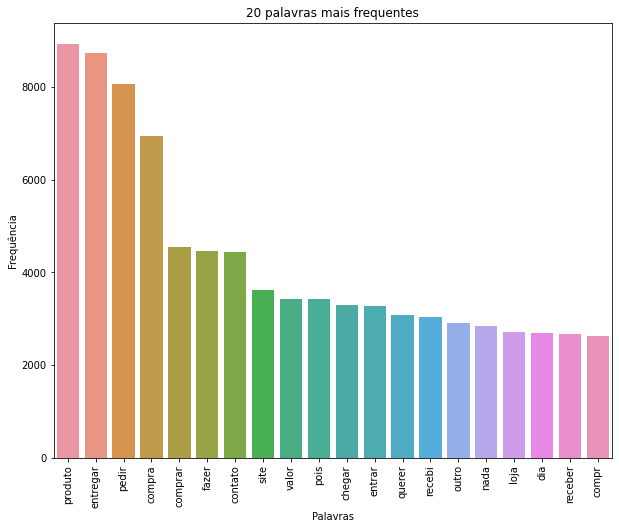

In [ ]:
plot_frequency_barchart(df, 'documents', 'preprocessed_v1_frequency')

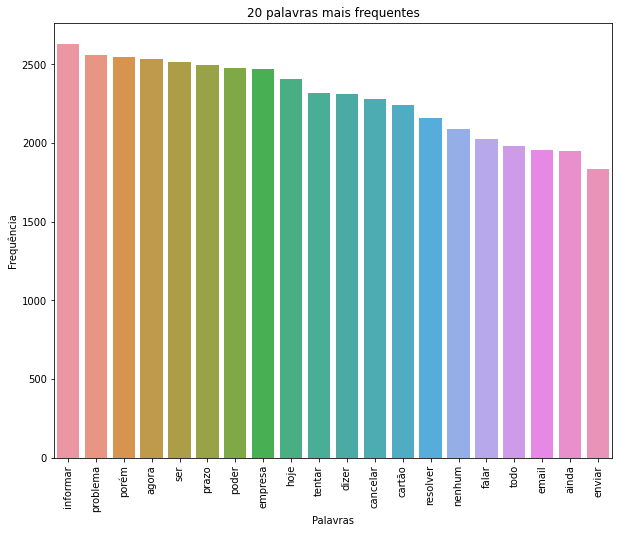

In [ ]:
plot_frequency_barchart(df2, 'documents', 'preprocessed_v2_frequency')

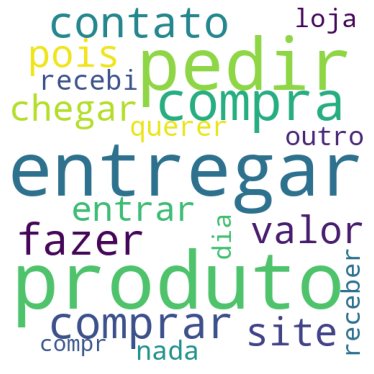

In [ ]:
plot_frequency_wordcloud(df, 'documents',  'preprocessed_v1_wordcloud')

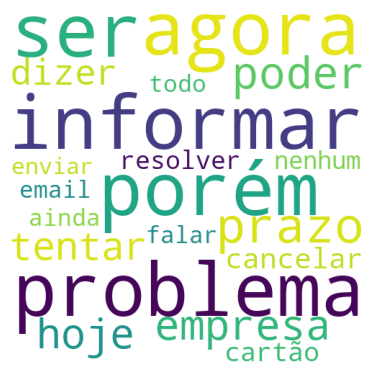

In [ ]:
plot_frequency_wordcloud(df2, 'documents',  'preprocessed_v2_wordcloud')

#### **Github**

In [ ]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:B/O5T4akBM6JbSikOUpRnLC7zwmp6b7G6iV5Oz9VM54 root@b404fae91cc3
The key's randomart image is:
+---[RSA 4096]----+
| .o..            |
|  oo             |
| o.   . o        |
| +o  * o B .     |
|+o. o * S O      |
|o.+. . o E o     |
|o* o  . . o o    |
|.+B.o.     +     |
|X=.=o..     .    |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-a17d9d27


In [ ]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDUPXSMgwhyv0BiEbpySgh8MJSX2W8nihPLgT2u35EOj92QYsD95sS3UMcnM053B6m2JlfM9FcJoxZU/WjYG4H8ZHlwc2A1833JH5+85XHQmxDCoz1jVAtjtcR6g2lNy/JOVEv5IJfyEvf0HIxlHIOyPOvqFEtDsiU/gCaRnK2RejQ7g30ATMa7mxWsx2PDkKFp9HJ8OLJHEmvM5zKTkSjYj9YqQ4IMNEYqkH3HKxaXlJHD4rii+DxUJsb3PEgYqg9ApErA0Q+fOFbg0F2eXnkQ98K0dwM4Kr0GyJIKEb05b/f5JP8P5IByD1u2KDdIKqgzQlFuOZuYaUfnqBONCxE1rsOHnx5PeuYRzpiKnUNF92OF6dkUgzJVwvG1mAeEeBP0R8mKupJWomwKIdiTEky96bPwp0PaNKnahj0lUGI5GzWnLFMk3ia0d4HQSjCEN/qUEAobVvBUGnxlfro2d+My232FkDBVTLY4NBiVnK5y+M09M8kRgG5rpagh2YM89XASdS1uUAZIZb0sLD+Fciv7VbtuGg7HPGGhn8gXCr7igtjHQymHmmkKW0SO1xb4aElKGWAthJhINtf3ZNqB0xC5Fprta9ciLadckSjMHe8sqWGhHvsKk7KqDh+f9Xs82NnVZvvKFODnzkwjiWcglvvCVvKHZnWsiuvgZv782rd3TQ== root@b404fae91cc3


In [ ]:
!git config --global user.email "mattheus_ribeiro@outlook.com"
!git config --global user.name "punkmic"

In [ ]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [ ]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

In [ ]:
%cd /content/Topic-Modeling-Reclame-Aqui/

/content/Topic-Modeling-Reclame-Aqui


In [ ]:
!git add ./datasets/

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	deleted:    datasets/frequent_words_wordcloud.png
	deleted:    datasets/preprocessed_top_20_removed.csv
	renamed:    datasets/preprocessed.csv -> datasets/preprocessed_v1.csv
	renamed:    datasets/frequent_words_barchart.png -> datasets/preprocessed_v1_frequency.png
	new file:   datasets/preprocessed_v1_wordcloud.png
	new file:   datasets/preprocessed_v2.csv
	renamed:    datasets/top_20_removed_frequent_words_barchart.png -> datasets/preprocessed_v2_frequency.png
	new file:   datasets/preprocessed_v2_wordcloud.png
	deleted:    datasets/top_20_removed_frequent_words_cloud.png



In [ ]:
!git commit -m "Renaming files"

[master b26db4f] Renaming files
 9 files changed, 10511 insertions(+), 10511 deletions(-)
 delete mode 100644 datasets/frequent_words_wordcloud.png
 delete mode 100644 datasets/preprocessed_top_20_removed.csv
 rename datasets/{preprocessed.csv => preprocessed_v1.csv} (100%)
 rename datasets/{frequent_words_barchart.png => preprocessed_v1_frequency.png} (100%)
 create mode 100644 datasets/preprocessed_v1_wordcloud.png
 create mode 100644 datasets/preprocessed_v2.csv
 rename datasets/{top_20_removed_frequent_words_barchart.png => preprocessed_v2_frequency.png} (100%)
 create mode 100644 datasets/preprocessed_v2_wordcloud.png
 delete mode 100644 datasets/top_20_removed_frequent_words_cloud.png


In [ ]:
!git push origin master

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 2.34 MiB | 2.21 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:punkmic/Topic-Modeling-Reclame-Aqui.git
   cd1b39a..b26db4f  master -> master


In [ ]:
# run this command to push a new version of this notebook in case you have saved the notebook in github and it is outdate 
!git stash
!git pull
!git stash pop

In [ ]:
!rm -rf /root/.ssh/